In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection
import glob
import tqdm
import os

In [2]:
if tf.config.list_physical_devices('GPU'):
    # Enable mixed precision
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled.")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9
Mixed precision enabled.


In [3]:
kaggle_config_dir = r"C:\Users\rakan\Downloads"

# Set the environment variable
os.environ['KAGGLE_CONFIG_DIR'] =  kaggle_config_dir

In [4]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.31G/1.33G [00:15<00:00, 131MB/s]
100% 1.33G/1.33G [00:15<00:00, 93.0MB/s]


In [ ]:
!unzip /content/celeba-dataset.zip

In [4]:
def make_pair(folder_path):

  files_list = glob.glob(folder_path+'/*.jpg')

  files_list_1=[]
  files_list_2=[]

  target_list = []

  for path in tqdm.tqdm(files_list):
    files_list_1.append(path)
    files_list_2.append(path)

    target_list.append(1)

    while True:

      n = np.random.randint(low=0, high = len(files_list))

      if files_list[n] != path:
        files_list_1.append(path)
        files_list_2.append(files_list[n])

        target_list.append(0)
        break


  data_dict = {
      'images_1':files_list_1,
      'images_2':files_list_2,
      'label':target_list
  }
  dataset = pd.DataFrame(data=data_dict)

  return dataset

In [5]:
df = make_pair(r"C:\Users\rakan\OneDrive\Desktop\Projects\img_align_celeba")
df

100%|██████████████████████████████████████████████████████████████████████| 202599/202599 [00:01<00:00, 195786.78it/s]


,images_1,images_2,label
0,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,1
1,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,0
2,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,1
3,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,0
4,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,1
...,...,...,...
405193,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,0
405194,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,1
405195,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,0
405196,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,C:\Users\rakan\OneDrive\Desktop\Projects\img_a...,1


In [6]:
train, test = model_selection.train_test_split(
    df, test_size = 0.1, random_state=42, stratify=df.label)

train.shape, test.shape

((364678, 3), (40520, 3))

In [7]:
def read_image(x, y):
  x1, x2 = x

  x1 = tf.io.read_file(x1)
  x1 = tf.image.decode_jpeg(x1, channels=3)
  x1 = tf.image.convert_image_dtype(x1, tf.float32)
  x1 = tf.image.resize(x1, (244, 244))
  x1 = tf.clip_by_value(x1, 0.0, 0.1)

  x2 = tf.io.read_file(x2)
  x2 = tf.image.decode_jpeg(x2, channels=3)
  x2 = tf.image.convert_image_dtype(x2, tf.float32)
  x2 = tf.image.resize(x2, (244, 244))
  x2 = tf.clip_by_value(x2, 0.0, 0.1)

  return (x1,x2), y

In [8]:
def train_preprocess(x, y):
  x1, x2 = x

  x1 = tf.image.random_flip_left_right(x1)
  x1 = tf.image.random_brightness(x1, max_delta=32.0/255.0)
  x1 = tf.image.random_saturation(x1, lower=0.5, upper=1.5)

  x2 = tf.image.random_flip_left_right(x2)
  x2 = tf.image.random_brightness(x2, max_delta=32.0/255.0)
  x2 = tf.image.random_saturation(x2, lower=0.5, upper=1.5)

  return (x1,x2), y

In [9]:
def dataset_creator(x1, x2, y, training=False):
  data = tf.data.Dataset.from_tensor_slices(((x1,x2), y))

  data = data.shuffle(1028)
  data = data.map(read_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  if training:
    data = data.map(train_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  data = data.batch(32)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data

# train, test
train_dataset = dataset_creator(train.images_1, train.images_2, train.label, training=True)
test_dataset = dataset_creator(test.images_1, test.images_2, test.label)

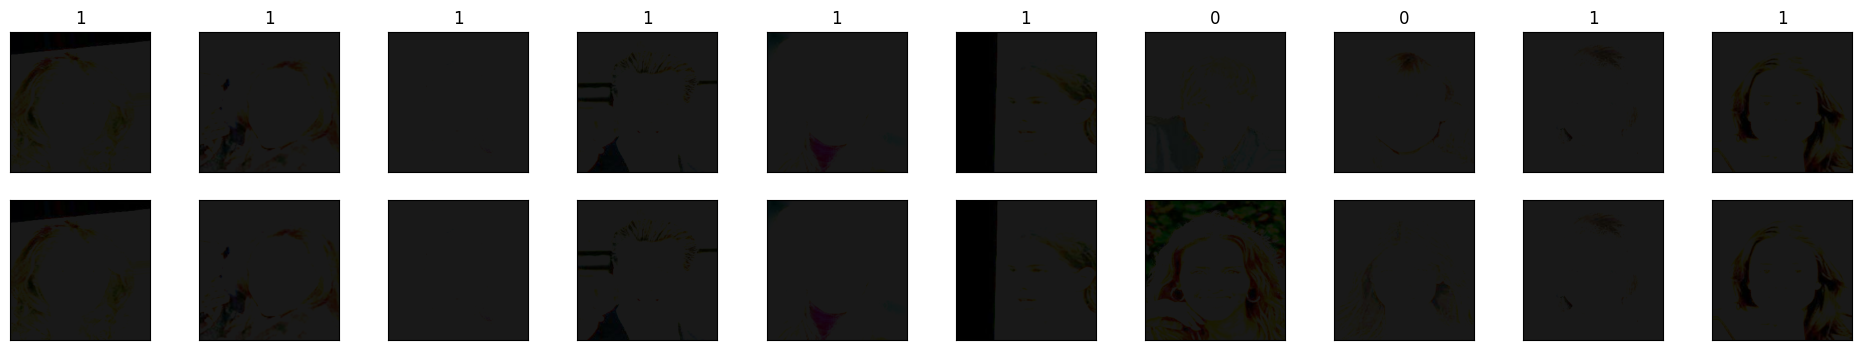

In [10]:
n=10
plt.figure(figsize=(24, 4))

for x, y in test_dataset.take(1):
  x1, x2 = x

  for i in range(n):
    plt.subplot(2, n, i+1)
    plt.title(f'{y[i]}')
    plt.imshow(tf.squeeze(x1[i]))
    plt.gray()
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, n, n+i+1)
    plt.imshow(tf.squeeze(x2[i]))
    plt.gray()
    plt.xticks([])
    plt.yticks([])


In [12]:
cnn_model = tf.keras.applications.DenseNet121(
    include_top=False,
    input_shape=(244, 244,3),
)
cnn_model.trainable = False
cnn_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 250, 250, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 122, 122, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [13]:
class EuclideanDistance(tf.keras.layers.Layer):
    def __init__(self):
        super(EuclideanDistance,self).__init__()

    def call(self,vectors):

        (featsA, featsB) = vectors
        sumSquared = tf.keras.backend.sum(tf.keras.backend.square(featsA - featsB), axis=1,
            keepdims=True)

        return tf.keras.backend.sqrt(tf.keras.backend.maximum(sumSquared, tf.keras.backend.epsilon()))

In [14]:
class SiameseModel(tf.keras.Model):
  def __init__(self, cnn_model):
      super(SiameseModel, self).__init__()

      self.cnn_model = cnn_model
      self.d1 = tf.keras.layers.Dense(512)
      self.bn1 = tf.keras.layers.BatchNormalization()
      self.d2 = tf.keras.layers.Dense(128)
      self.bn2 = tf.keras.layers.BatchNormalization()
      self.out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x1, x2 = inputs
    x1 = self.cnn_model(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    x2 = self.cnn_model(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

    x = tf.keras.layers.concatenate([x1, x2])
    x = self.d1(x)
    x = self.bn1(x)
    x = tf.nn.leaky_relu(x)
    x = self.d2(x)
    x = self.bn2(x)
    x = tf.nn.leaky_relu(x)
    output = self.out(x)
    return output

  def build_model(self, dim=[244,244,3]):
    x = (tf.keras.layers.Input(dim), tf.keras.layers.Input(dim))
    return tf.keras.Model(inputs=[x], outputs=[self.call(x)])


model = SiameseModel(cnn_model)
model.build_model(dim=[244,244,3]).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 7, 7, 1024)   7037504     ['input_3[0][0]',                
                                                                  'input_4[0][0]']            

In [15]:
tf.keras.utils.plot_model(model.build_model(dim=[244,244,3]))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
model.compile('adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.fit(train_dataset, epochs=3, validation_data=test_dataset)

Epoch 1/3
11397/11397 [==============================] - 2068s 180ms/step - loss: 0.1738 - acc: 0.9307 - val_loss: 0.0508 - val_acc: 0.9806
Epoch 2/3
11397/11397 [==============================] - 2120s 186ms/step - loss: 0.1097 - acc: 0.9581 - val_loss: 0.0338 - val_acc: 0.9873
Epoch 3/3
11397/11397 [==============================] - 2046s 180ms/step - loss: 0.0955 - acc: 0.9635 - val_loss: 0.0284 - val_acc: 0.9891
